<a href="https://colab.research.google.com/github/MahaJayapal/usd-computer-vision/blob/main/VGG16_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Colab compatibility
from google.colab import drive
drive.mount('/content/drive')
!pip install opendatasets

Mounted at /content/drive


In [2]:

# Import Libraries
import opendatasets as od
import os
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import random
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping




# Preprocessing and Exploration

In [3]:
# Download path
download_path = '/content/drive/MyDrive/Colab Notebooks/Computer_Vision_Project'
os.chdir(download_path)

# # Load dataset from Kaggle
# od.download("https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification",
#             data_dir=download_path)

# # Define the path to the main images folder
# image_folder = './recyclable-and-household-waste-classification/images/images'

# # Traverse the subdirectories and list images
# image_paths = []
# for root, dirs, files in os.walk(image_folder):
#     for file in files:
#         # Append full path for each image file
#         image_paths.append(os.path.join(root, file))




In [4]:
# Print total number of images
print(len(image_paths))

15000


./recyclable-and-household-waste-classification/images/images/aerosol_cans/default/Image_1.png


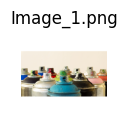

./recyclable-and-household-waste-classification/images/images/aerosol_cans/default/Image_10.png


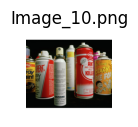

./recyclable-and-household-waste-classification/images/images/aerosol_cans/default/Image_100.png


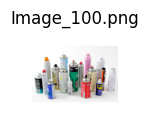

./recyclable-and-household-waste-classification/images/images/aerosol_cans/default/Image_101.png


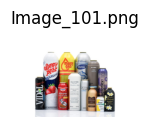

./recyclable-and-household-waste-classification/images/images/aerosol_cans/default/Image_102.png


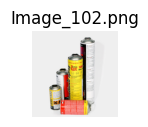

In [5]:
# Display a few sample images
for i, image_path in enumerate(image_paths[:5]):  # Show the first 5 images
    print(image_path)
    image = Image.open(image_path)

    # Display the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
    plt.show()

In [9]:
from PIL import Image
import os

def check_images(directory):
    invalid_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.png'):
                try:
                    img = Image.open(os.path.join(root, file))
                    img.verify()  # Verify image integrity
                except Exception as e:
                    invalid_images.append(os.path.join(root, file))
    return invalid_images

invalid_train = check_images(train_dir)
invalid_test = check_images(test_dir)

print(f"Invalid train images: {len(invalid_train)}")
print(f"Invalid test images: {len(invalid_test)}")


Invalid train images: 0
Invalid test images: 0


In [4]:
# Define paths
dataset_dir = './recyclable-and-household-waste-classification/images/images'
train_dir = './split_dataset/train/images'
test_dir = './split_dataset/test/images'

# # Ensure train and test directories exist
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# # Initialize counters
# train_count = 0
# test_count = 0

# # Process each class in the dataset directory
# for class_name in os.listdir(dataset_dir):
#     class_path = os.path.join(dataset_dir, class_name)
#     if os.path.isdir(class_path):  # Ensure it’s a directory (class folder)
#         # Create class folders in train and test directories
#         os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
#         os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

#         # Collect all image file paths from any subdirectories within this class folder
#         images = []
#         for root, _, files in os.walk(class_path):
#             for file in files:
#                 if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image file extensions
#                     images.append(os.path.join(root, file))

#         # Shuffle and split images into 80/20 train/test sets
#         random.shuffle(images)
#         split_idx = int(len(images) * 0.8)
#         train_images = images[:split_idx]
#         test_images = images[split_idx:]

#         # Copy images to train and test directories
#         for image_path in train_images:
#             subfolder_name = os.path.basename(os.path.dirname(image_path))
#             unique_name = f"{subfolder_name}_{os.path.basename(image_path)}"
#             dest_path = os.path.join(train_dir, class_name, unique_name)
#             shutil.copyfile(image_path, dest_path)
#             train_count += 1

#         for image_path in test_images:
#             subfolder_name = os.path.basename(os.path.dirname(image_path))
#             unique_name = f"{subfolder_name}_{os.path.basename(image_path)}"
#             dest_path = os.path.join(test_dir, class_name, unique_name)
#             shutil.copyfile(image_path, dest_path)
#             test_count += 1

# # Print total counts
# print(f"Dataset successfully split into train and test folders!")
# print(f"Total train images: {train_count}")
# print(f"Total test images: {test_count}")


In [5]:
# Function to count files in a directory (recursively)
def count_files_in_directory(directory):
    return sum([len(files) for _, _, files in os.walk(directory)])

# Count files in train and test directories
total_train_files = count_files_in_directory(train_dir)
total_test_files = count_files_in_directory(test_dir)

# Print the counts
print(f"Total files in train directory: {total_train_files}")
print(f"Total files in test directory: {total_test_files}")

Total files in train directory: 12000
Total files in test directory: 3000


In [6]:
# Create Data Generator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% of data for validation
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Generate training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Generate validation data
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Generate test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 9600 images belonging to 30 classes.
Found 2400 images belonging to 30 classes.
Found 3000 images belonging to 30 classes.


# Finetuning VGG16 model

In [7]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load VGG16 without the top layers to prepare for transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base to retain the pre-trained weights
base_model.trainable = False



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [8]:
# Build model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(30, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 30)                  │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,936,286 (68.42 MB)

 Trainable params: 3,221,598 (12.29 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,          # Stop if no improvement for 5 epochs
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping],
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    validation_steps=validation_generator.samples//validation_generator.batch_size
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


181/300 ━━━━━━━━━━━━━━━━━━━━ 42:50 22s/step - accuracy: 0.0519 - loss: 3.4170

In [ ]:
# Save model
model.save('/content/drive/MyDrive/Colab Notebooks/Computer_Vision_Project/vgg_model')

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
